In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import shutil

In [2]:
sub = pd.read_csv('merged_data/test_challenge.csv', names=['image_name', 'class'],header=0) #Changing column names from 0,1 for convenient handling
df = pd.read_csv('merged_data/train_challenge.csv', names=['image_name', 'class'],header=0)
df.head()

,image_name,class
0,0.jpg,Adhered
1,1.jpg,Adhered
2,2.jpg,Concrete
3,3.jpg,Concrete
4,4.jpg,Plastic & fabric


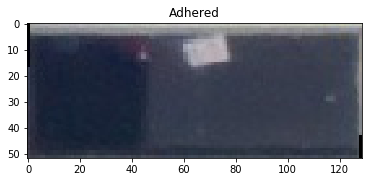

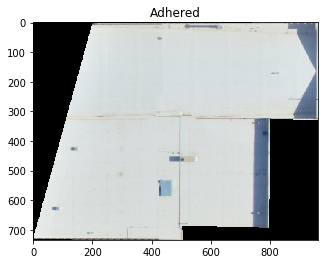

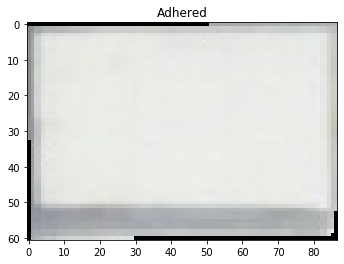

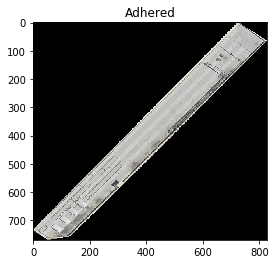

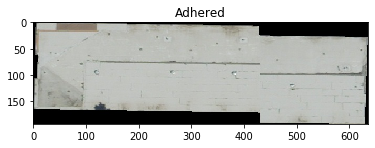

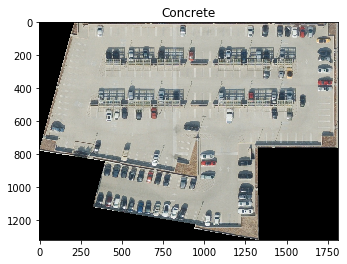

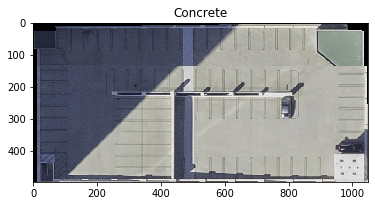

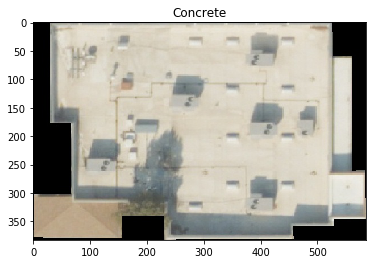

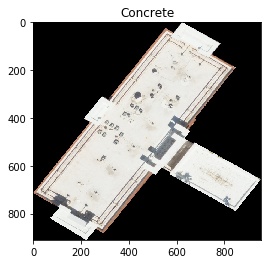

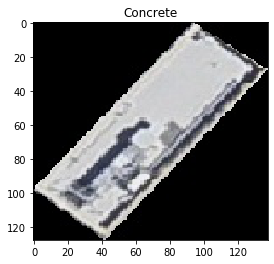

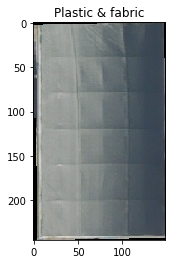

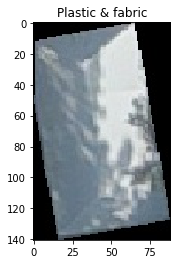

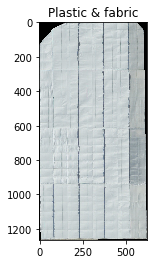

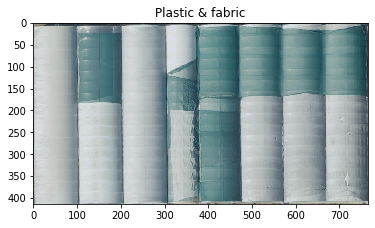

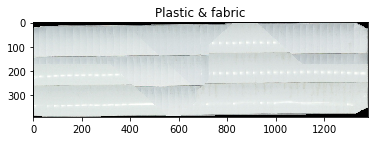

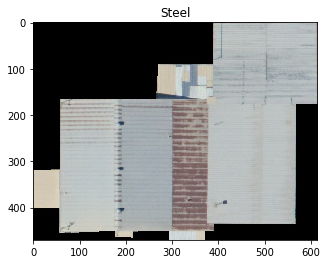

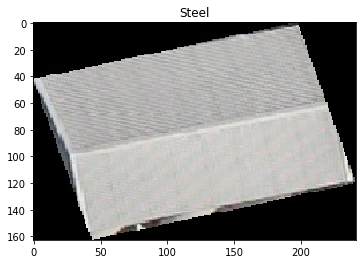

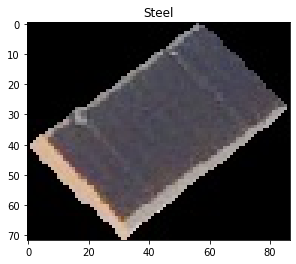

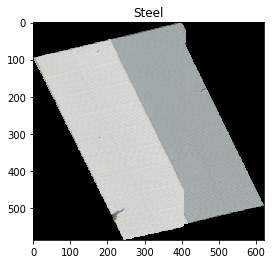

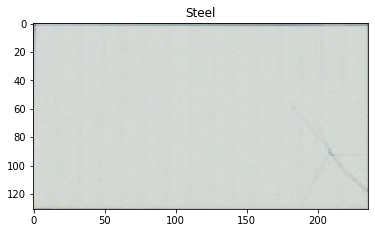

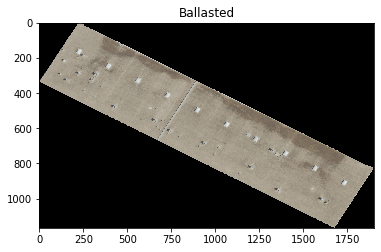

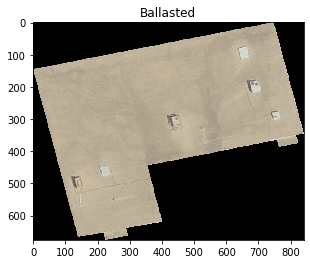

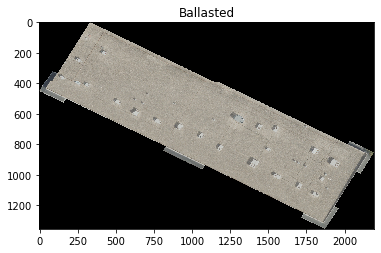

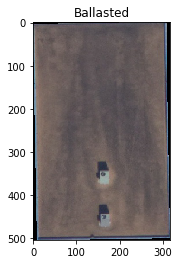

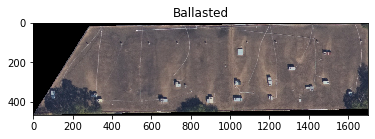

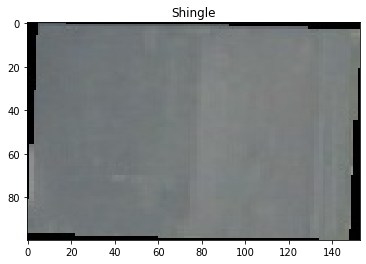

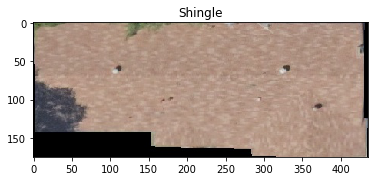

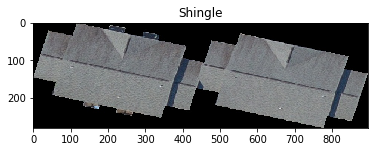

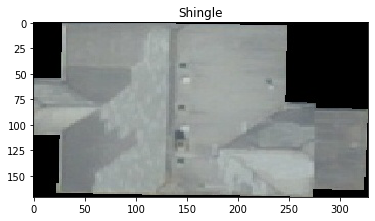

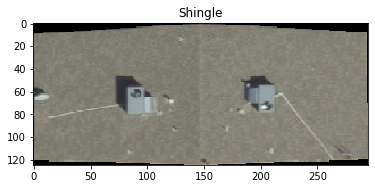

In [3]:
for i in df.iloc[:,1].unique():
    for ind, row in df[df['class']==i].sample(5).iterrows():
        
        path = os.path.join('merged_data/train/', row['image_name'])
        img = plt.imread(path)
        plt.imshow(img)
        plt.title(row[1])
        plt.show()

**Exploring Dimensions of Images for appropriate resizing**

In [4]:
def capture_dim(image_name, train=True):
    """collect dimensions of all images"""
    
    if train:
        img_path = os.path.join('merged_data/train/', image_name)
    else:
        img_path = os.path.join('merged_data/test/', image_name)
        
    img = plt.imread(img_path)
    return img.shape

In [5]:
%%time
dim_df = df.copy()
dim_df['dimensions'] = dim_df['image_name'].apply(lambda x: capture_dim(x))

Wall time: 4min 10s


In [7]:
%%time
dim_test = pd.DataFrame({'image_name':range(596)},index=range(596), dtype=str)
dim_test['image_name'] = dim_test['image_name'] + '.jpg'
dim_test['dimensions'] = dim_test['image_name'].apply(lambda x: capture_dim(x, train=False))

Wall time: 19.7 s


In [20]:
dim_df.head()

,image_name,class,dimensions
0,0.jpg,Adhered,"(461, 1063, 3)"
1,1.jpg,Adhered,"(282, 190, 3)"
2,2.jpg,Concrete,"(72, 80, 3)"
3,3.jpg,Concrete,"(73, 103, 3)"
4,4.jpg,Plastic & fabric,"(120, 150, 3)"


In [21]:
assert(dim_df.dimensions.apply(len).unique()==3)
print('All images in training have 3 channels')

All images in training have 3 channels


In [17]:
assert(dim_test.dimensions.apply(len).unique()==3)
print('All images in testing have 3 channels')

All images in testing have 3 channels


**Distribution of image sizes**

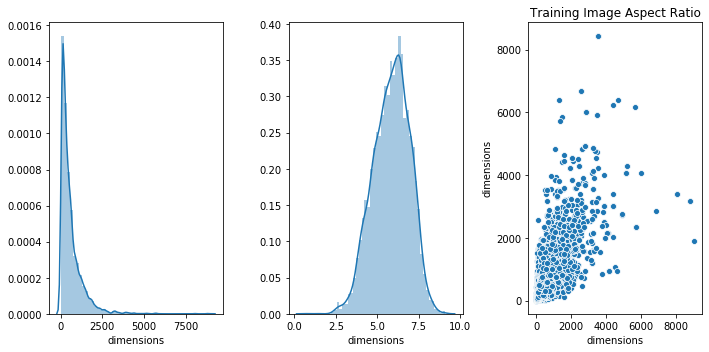

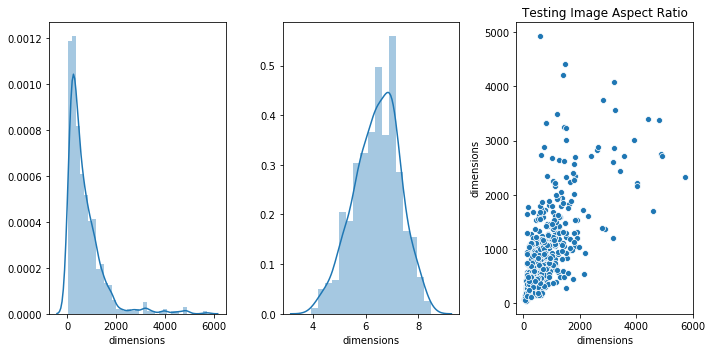

In [71]:
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
sns.distplot(dim_df.dimensions.apply(lambda x: x[0]))
plt.subplot(1,3,2)
sns.distplot(dim_df.dimensions.apply(lambda x: x[0]).apply(np.log1p))
plt.subplot(1,3,3)
sns.scatterplot(x=dim_df.dimensions.apply(lambda x: x[0]), y=dim_df.dimensions.apply(lambda x: x[1]))
plt.title('Training Image Aspect Ratio')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
sns.distplot(dim_test.dimensions.apply(lambda x: x[0]))
plt.subplot(1,3,2)
sns.distplot(dim_test.dimensions.apply(lambda x: x[1]).apply(np.log1p))
plt.subplot(1,3,3)
sns.scatterplot(x=dim_test.dimensions.apply(lambda x: x[0]), y=dim_test.dimensions.apply(lambda x: x[1]))
plt.title('Testing Image Aspect Ratio')
plt.tight_layout()
plt.show()

Have images from really small sizes to really large sizes

In [30]:
dim_df[dim_df.dimensions.apply(lambda x: x[0])>2000]

,image_name,class,dimensions
567,567.jpg,Adhered,"(2109, 880, 3)"
606,606.jpg,Adhered,"(2365, 877, 3)"
607,607.jpg,Adhered,"(2259, 832, 3)"
945,945.jpg,Shingle,"(2386, 2274, 3)"
978,978.jpg,Shingle,"(2669, 2500, 3)"
...,...,...,...
8618,8618.jpg,Adhered,"(3841, 2812, 3)"
8619,8619.jpg,Adhered,"(2316, 3215, 3)"
8622,8622.jpg,Adhered,"(2613, 1752, 3)"
8641,8641.jpg,Adhered,"(6005, 4070, 3)"


In [34]:
def plot_image(img_name, train=True):
    if train:
        img_path = os.path.join('merged_data/train/', img_name)
    else:
        img_path = os.path.join('merged_data/test/', img_name)
        
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.show()

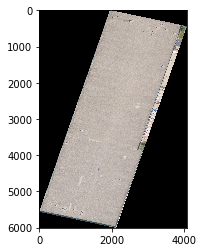

In [37]:
plot_image('8641.jpg')

**Checking class imbalance**

In [77]:
df['class'].value_counts(normalize=True)*100

Steel               26.862564
Adhered             26.850995
Concrete            13.257751
Shingle             12.401666
Plastic & fabric    12.355391
Ballasted            8.271634
Name: class, dtype: float64

High Class Imbalance

In [7]:
df['class'].value_counts()

Steel               2322
Adhered             2321
Concrete            1146
Shingle             1072
Plastic & fabric    1068
Ballasted            715
Name: class, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

In [57]:
train_df = df.copy()
valid_df = pd.DataFrame()
for category in train_df['class'].unique():
    data = train_df[train_df['class']==category].sample(150, random_state=42)
    valid_df = pd.concat([valid_df, data])
    train_df.drop(data.index, inplace=True)

In [85]:
train_df.to_csv('train_df.csv', index=False)
valid_df.to_csv('valid_df.csv', index=False)

In [58]:
%%time
data_path = 'merged_data/train/'
val_path = 'validation/'
train_path = 'training/'
os.mkdir(val_path)
os.mkdir(train_path)
for i in os.listdir(data_path):

    if i in valid_df.image_name.tolist():
        shutil.copy(src=(data_path+i), dst=(val_path+i))
    else:
        shutil.copy(src=(data_path+i), dst=(train_path+i))

Wall time: 7min 26s


In [68]:
os.mkdir('validation_gen')
os.mkdir('training_gen')

In [69]:
for i in df['class'].unique():
    os.mkdir('validation_gen/'+i)
    os.mkdir('training_gen/'+i)

In [80]:
val_base_path = 'validation/'
val_gen_path = 'validation_gen/'
for ind, row in valid_df.iterrows():
    image_name = valid_df.loc[ind, 'image_name']
    category = valid_df.loc[ind, 'class']
    
    shutil.copy(src=(val_base_path+image_name), dst=(val_gen_path+ f'/{category}/'+''+image_name))

In [81]:
%%time
train_base_path = 'training/'
train_gen_path = 'training_gen/'
for ind, row in train_df.iterrows():
    image_name = train_df.loc[ind, 'image_name']
    category = train_df.loc[ind, 'class']
    
    shutil.copy(src=(train_base_path+image_name), dst=(train_gen_path+ f'/{category}/'+''+image_name))

Wall time: 7min 55s
